In [28]:
import pandas as pd
import numpy as np
ONLY_ORGANIC = True
data = pd.read_csv('only_organic_effect_data.csv' if ONLY_ORGANIC else 'effect_data.csv',index_col=0)

In [29]:
data

,species,chemical,conc (mol/L)
0,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100414,3.398977
1,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100425,3.512146
2,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100447,4.237130
3,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100516,2.147166
4,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100527,3.610505
...,...,...,...
4426,https://cfpub.epa.gov/ecotox/taxon/9943,https://cfpub.epa.gov/ecotox/cas/110918,3.062257
4427,https://cfpub.epa.gov/ecotox/taxon/997,https://cfpub.epa.gov/ecotox/cas/148243,0.582372
4428,https://cfpub.epa.gov/ecotox/taxon/997,https://cfpub.epa.gov/ecotox/cas/50293,6.004827
4429,https://cfpub.epa.gov/ecotox/taxon/997,https://cfpub.epa.gov/ecotox/cas/52645531,6.312399


<AxesSubplot:>

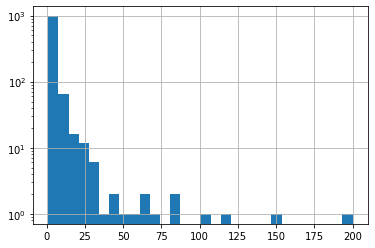

In [57]:
data.groupby('species').count().chemical.hist(bins=30,log=True)

<AxesSubplot:>

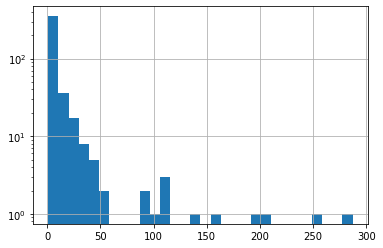

In [58]:
data.groupby('chemical').count().species.hist(bins=30,log=True)

(4.146954748369991, 1.8141159210326503)

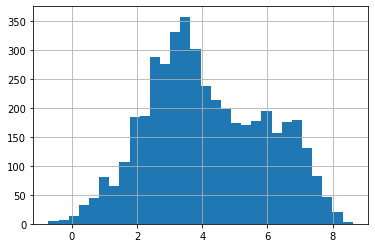

In [59]:
data['conc (mol/L)'].hist(bins=30)
data['conc (mol/L)'].mean(),data['conc (mol/L)'].std()

In [33]:
mapping_species = {k:i for i,k in enumerate(data.species.unique())}
mapping_chemical = {k:i for i,k in enumerate(data.chemical.unique())}

In [34]:
M = np.zeros((len(mapping_species),len(mapping_chemical)))

In [35]:
for i,j in zip(data.species,data.chemical):
    i = mapping_species[i]
    j = mapping_chemical[j]
    M[i,j] = 1

In [36]:
np.unique(M,return_counts=True)

(array([0., 1.]), array([465359,   4431]))

In [37]:
import networkx as nx

G = nx.DiGraph()

for s,c in zip(data.species,data.chemical):
    G.add_edge(s,c)
    G.add_edge(c,s)
    
edges_to_remove = []
for edge in G.edges():
    if (edge[1],edge[0]) in G.edges() and (edge[1],edge[0]) not in edges_to_remove:
        edges_to_remove.append(edge)
        
for edge in edges_to_remove:
    G.remove_edge(*edge)

In [38]:
G.number_of_nodes(),G.number_of_edges()

(1521, 4431)

In [39]:
nx.algorithms.dag.dag_longest_path(G)

['https://cfpub.epa.gov/ecotox/cas/108736',
 'https://cfpub.epa.gov/ecotox/taxon/70',
 'https://cfpub.epa.gov/ecotox/cas/123308',
 'https://cfpub.epa.gov/ecotox/taxon/5156',
 'https://cfpub.epa.gov/ecotox/cas/100663',
 'https://cfpub.epa.gov/ecotox/taxon/4752',
 'https://cfpub.epa.gov/ecotox/cas/95534',
 'https://cfpub.epa.gov/ecotox/taxon/25',
 'https://cfpub.epa.gov/ecotox/cas/106956',
 'https://cfpub.epa.gov/ecotox/taxon/206',
 'https://cfpub.epa.gov/ecotox/cas/107926',
 'https://cfpub.epa.gov/ecotox/taxon/2',
 'https://cfpub.epa.gov/ecotox/cas/120127',
 'https://cfpub.epa.gov/ecotox/taxon/142',
 'https://cfpub.epa.gov/ecotox/cas/479458',
 'https://cfpub.epa.gov/ecotox/taxon/1196',
 'https://cfpub.epa.gov/ecotox/cas/88891',
 'https://cfpub.epa.gov/ecotox/taxon/109',
 'https://cfpub.epa.gov/ecotox/cas/52315078',
 'https://cfpub.epa.gov/ecotox/taxon/102',
 'https://cfpub.epa.gov/ecotox/cas/52918635',
 'https://cfpub.epa.gov/ecotox/taxon/1015',
 'https://cfpub.epa.gov/ecotox/cas/121755

In [40]:
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import RDF, Namespace

tax = Graph()
tax.load('../TERA_OUTPUT/ecotox_taxonomy.nt',format='nt')

chem = Graph()
chem.load('only_organic_reduced_kgs/reduced_chebi.ttl' if ONLY_ORGANIC else 'reduced_kgs/reduced_chebi.ttl',format='ttl')


In [41]:
#TODO add chemical and tax group exploration.

other = ['https://cfpub.epa.gov/ecotox/group/StandardTestSpecies',
        'https://cfpub.epa.gov/ecotox/group/U.S.Exotic/NuisanceSpecies',
        'https://cfpub.epa.gov/ecotox/group/U.S.ThreatenedandEndangeredSpecies']

divs = []
others = []
for s in data.species:
    uri = URIRef(s)
    div = sorted(list(map(str,tax.objects(subject=uri,predicate=URIRef('https://cfpub.epa.gov/ecotox/ecotoxGroup')))))
    idx = [div.index(o) for o in other if o in div]
    
    ot = ','.join(div[i] for i in idx)
    if ot == ',': ot = None
    
    div = [div[i] for i in range(len(div)) if i not in idx][0]
    
    others.append(ot)
    divs.append(div)

data['species_divisions'] = divs
data['species_others'] = others


In [42]:
data.groupby('species_divisions').count()

,species,chemical,conc (mol/L),species_others
species_divisions,,,,
https://cfpub.epa.gov/ecotox/group/Algae,12,12,12,12
https://cfpub.epa.gov/ecotox/group/Amphibians,214,214,214,214
https://cfpub.epa.gov/ecotox/group/Birds,2,2,2,2
https://cfpub.epa.gov/ecotox/group/Crustaceans,1020,1020,1020,1020
https://cfpub.epa.gov/ecotox/group/Ferns,1,1,1,1
https://cfpub.epa.gov/ecotox/group/Fish,1634,1634,1634,1634
https://cfpub.epa.gov/ecotox/group/Insects/Spiders,995,995,995,995
https://cfpub.epa.gov/ecotox/group/Invertebrates,90,90,90,90
https://cfpub.epa.gov/ecotox/group/Miscellaneous,2,2,2,2


In [43]:
import tqdm.notebook as tq


for p in ['http://www.w3.org/2000/01/rdf-schema#subClassOf']:

    divs = []
    for c in tq.tqdm(data.chemical):
        uri = URIRef(c)
        
        q = """
            select ?c where {
                ?s rdfs:subClassOf* ?c .
                ?c rdfs:subClassOf ?top .
            }"""
        
        div = chem.query(q,initNs={'rdfs':Namespace('http://www.w3.org/2000/01/rdf-schema#')},
                        initBindings={'s':URIRef(c),
                                      'top':URIRef('http://purl.obolibrary.org/obo/CHEBI_72695')}) #organi
        div = sorted([d[0] for d in div if not isinstance(d[0],BNode)])
        
        div = ','.join(div)
        if div == ',': div = None

        divs.append(str(div))

    singles = set([d for d in divs if len(d.split(','))<2])
    
    divs = [d.split(',')[0] if len(d.split(','))>1 else d for d in divs]
        
    data[p.split('#')[-1]] = divs


In [44]:
data.groupby('subClassOf').count()

,species,chemical,conc (mol/L),species_divisions,species_others
subClassOf,,,,,
,1222,1222,1222,1222,1222
http://purl.obolibrary.org/obo/CHEBI_134179,432,432,432,432,432
http://purl.obolibrary.org/obo/CHEBI_33832,2110,2110,2110,2110,2110
http://purl.obolibrary.org/obo/CHEBI_35716,138,138,138,138,138
http://purl.obolibrary.org/obo/CHEBI_36587,527,527,527,527,527
http://purl.obolibrary.org/obo/CHEBI_51151,2,2,2,2,2


In [45]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?smiles where {
  [] wdt:P233 ?smiles ;
     wdt:P231 ?cas .
}"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

cas_to_smiles = {}

for result in results["results"]["bindings"]:
    cas = result['cas']['value'].replace('-','')
    smiles = result['smiles']['value']
    cas_to_smiles[cas] = smiles

In [46]:
data['smiles']=list(map(lambda x:cas_to_smiles[x.split('/')[-1]] if x.split('/')[-1] in cas_to_smiles else None, data.chemical))

In [47]:
!git clone https://github.com/Erik-BM/pySMIfp

fatal: destination path 'pySMIfp' already exists and is not an empty directory.


In [48]:
from pySMIfp.smiles_fingerprints import smiles_fingerprint

In [49]:
smiles_fp = data['smiles'].apply(lambda x: smiles_fingerprint(x) if x else None)

In [50]:
idx = [i for i,e in enumerate(smiles_fp.values) if e is not None]

In [51]:
smiles_fp = [np.asarray(s) for s in smiles_fp.values if s is not None]

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
kmeans.fit(np.unique(smiles_fp,axis=0))

KMeans(n_clusters=5)

In [53]:
data['smiles_clusters'] = -1

In [54]:
data.loc[idx,'smiles_clusters'] = kmeans.predict(smiles_fp)

In [55]:
data.groupby('smiles_clusters').count()

,species,chemical,conc (mol/L),species_divisions,species_others,subClassOf,smiles
smiles_clusters,,,,,,,
-1,34,34,34,34,34,34,0
0,673,673,673,673,673,673,673
1,1849,1849,1849,1849,1849,1849,1849
2,14,14,14,14,14,14,14
3,1838,1838,1838,1838,1838,1838,1838
4,23,23,23,23,23,23,23


In [56]:
data.to_csv('only_organic_effect_data_extra.csv' if ONLY_ORGANIC else 'effect_data_extra.csv')